# Identification of a 1-DOF Mass-Spring-Damper System with a Discrete-time ARX Model

***

System identification is a discipline that develops mathematical models of dynamic systems based on experimental data. It is like being a detective for machines - think of it as uncovering the hidden mathematical "personality" of a dynamic system by studying the traces it leaves behind in the data.

In the realm of vibration analysis, there are two main approaches to system identification: Experimental Modal Analysis (EMA) and Operational Modal Analysis (OMA). EMA involves exciting the structure with known input forces and measuring both the input forces and output responses, giving us complete control over the testing conditions. Wearing our detective hat, we can think of EMA as interrogating a suspect in a controlled environment. OMA, on the other hand, relies solely on measuring the system's response to ambient excitation during normal operation - it's more like surveillance work, similar to a detective conducting a stakeout.

In this first notebook, we'll focus on EMA as it provides a more straightforward introduction to system identification concepts.

The process follows a methodology with four key steps, much like solving a mystery at a crime scene:

1. **Data Acquisition**: We collect experimental measurements of the system's input and output signals in either time or frequency domain - similar to gathering evidence at a crime scene, where every piece of data tells part of the story.
2. **Model Structure Selection**: We choose an appropriate mathematical framework to represent the system's dynamics - like selecting the right tools for the investigation based on the type of case we're solving.
3. **Parameter Estimation**: Using estimation algorithms, we determine the optimal values for the model parameters - this is like connecting the dots of the evidence and creating a psychological profile of our suspect.
4. **Model Validation**: We evaluate the model's performance against unseen experimental data to ensure it accurately represents the system's behavior - just as a detective must verify their conclusions before closing a case.

In this notebook, we'll explore system identification using a single degree-of-freedom (1-DOF) mass-spring-damper system - the "Hello World" of dynamic systems, if you will. We'll use a discrete-time AutoRegressive eXogenous (ARX) model to capture its behavior, which, despite its fancy name, is really just a way of saying "the future depends on both the past and present." In other words, it's like predicting tomorrow's weather based on today's conditions and yesterday's patterns.

* [Data Acquisition](#data-acquisition)
* [Model Structure Selection](#model-structure-selection)
* [Parameter Estimation](#parameter-estimation)
* [Model Validation](#model-validation)
* [Conclusion](#conclusion)

This notebook has been inspired by the YouTube video below by Dr. James E. Pickering from the University of Birmingham.

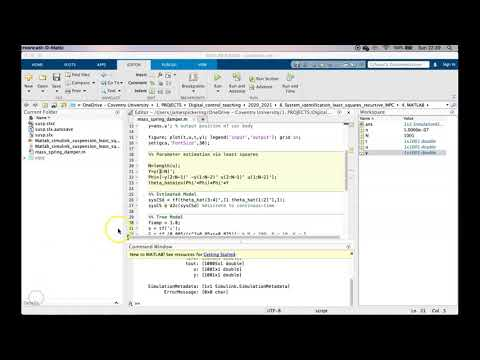

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo("NZPSmo1vbUY", width=800, height=450)

## Data Acquisition <a name="data-acquisition"></a>

***

Let's start by generating some synthetic data from the 1-DOF mass-spring-damper system below with mass $m = 8$ kg, spring constant $k = 4000$ N/m, and damping coefficient $c = 40$ Ns/m:

![1-DOF Mass-Spring-Damper System](resources/01_MassSpringDamper.svg)

In [2]:
MASS = 8  # mass [kg]
STIFFNESS = 4000  # stiffness constant [N/m]
DAMPING = 40  # damping constant [Ns/m]


For our investigation, we are going to observe the system's response in terms of the displacement $x(t)$ when an input force $F(t)$ is applied to the mass.

The system's dynamics can be described by the following second-order ordinary differential equation (ODE):

$$m\ddot{x}(t) + c\dot{x}(t) + kx(t) = F(t)$$

where the dot notation represents the derivative with respect to time.

To generate the synthetic data, we are going to solve the ODE using the numerical solver `odeint` from the `scipy.integrate` module, and to use this solver, we need to convert the second-order ODE into a system of first-order ODEs. We can do this by defining the state vector $\boldsymbol{q}(t)$:

$$\boldsymbol{q}(t) = \begin{bmatrix} q_1(t) \\ q_2(t) \end{bmatrix} = \begin{bmatrix} x(t) \\ \dot{x}(t) \end{bmatrix},$$

and by rewriting the original equation in the following way:

$$\begin{cases} \dot{q}_1(t) = q_2(t) \\[2ex] \dot{q}_2(t) = \dfrac{- kq_1(t) -cq_2(t) + F(t)}{m}. \end{cases}$$

Now, we can define the function `mass_spring_damper`, which takes the state vector $\boldsymbol{q}(t)$, the time instant $t$ and the force function $F(t)$ as inputs, and returns the derivative of the state vector $\dot{\boldsymbol{q}}(t)$. 

In [3]:
def mass_spring_damper(state, t, force):
    """
    Define system dynamics: dq/dt = f(q, t)

    Parameters:
    state (array): [displacement, velocity]
    t (float): Time
    force (function): External force signal, inputted as a function

    Returns:
    array: State derivatives [velocity, acceleration]
    """
    # Unpack state variables
    x, xdot = state

    # Calculate acceleration based on the equation of motion
    xddot = (-STIFFNESS * x - DAMPING * xdot + force(t)) / MASS

    # Return state derivatives
    return [xdot, xddot]

Successively, we are going to generate the input signal for our force $F(t)$. In EMA, three main techniques are typically employed to excite the system: sweep sine, random vibration and impulse testing. In this notebook, we are going to use all three techniques to generate the input signal, in order to assess the system identification performance under different excitation conditions.

For all the three techniques, we excite the system for 20 seconds with a sampling frequency of 100 Hz, meaning that we acquire 2000 samples for both the input and output signals.

Let's start from the sweep sine excitation. We define a chirp signal with a frequency range from 0.1 Hz to 10 Hz, and an amplitude of 100 N. The chirp signal is a sinusoidal signal whose frequency increases linearly with time. Then we define the function `sweep_sine_force_function` that takes the time instant $t$ as input and returns the value of the force $F(t)$ based on the chirp signal.

Finally, we can solve the ODE using the `odeint` solver and plot the input and output signals.

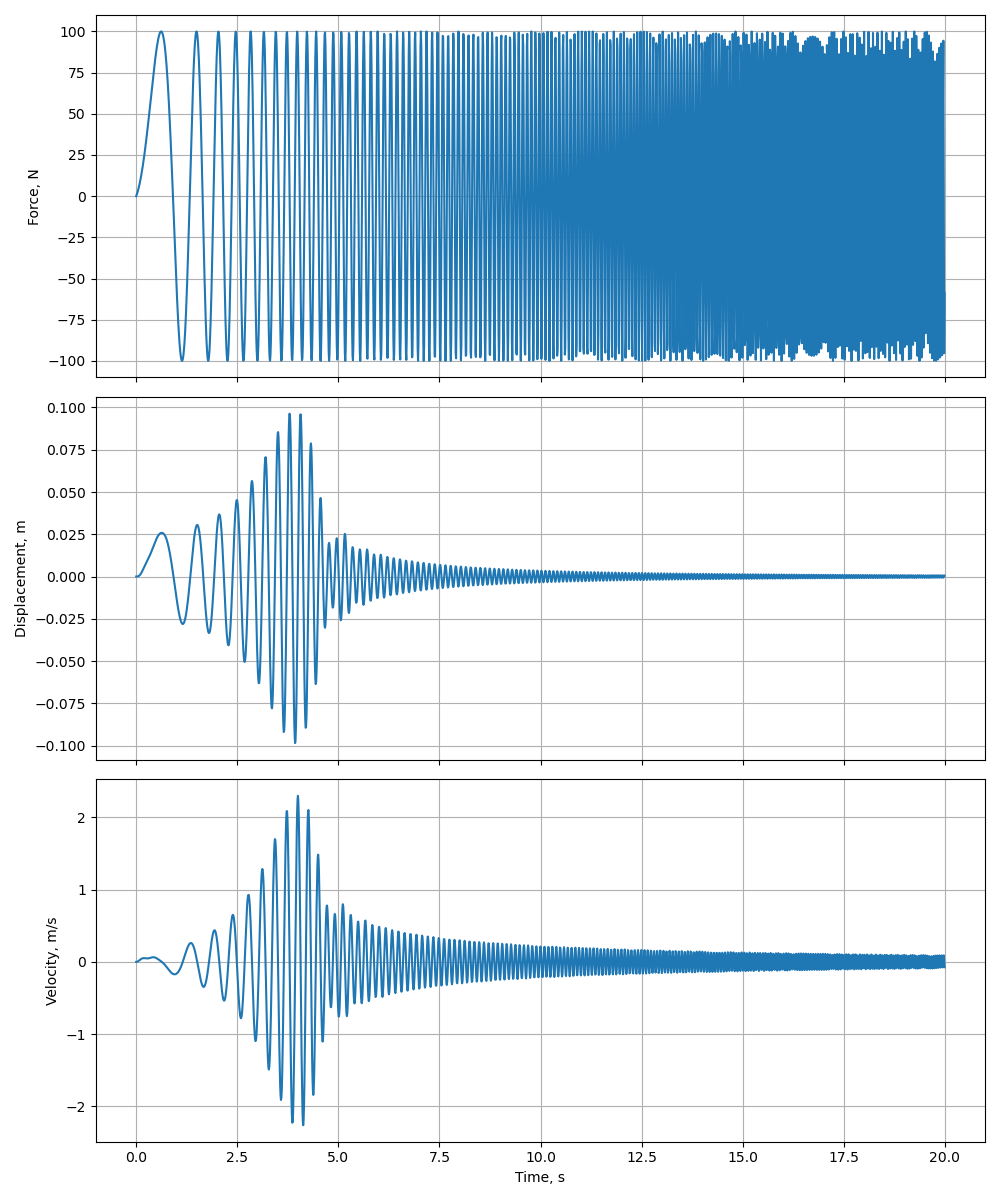

In [4]:
import numpy as np  # import numpy library for numerical calculations
from scipy.interpolate import interp1d  # import interp1d function for interpolation
from scipy.integrate import odeint  # import odeint function for solving ODEs
import matplotlib.pyplot as plt  # import matplotlib library for plotting

# Enable interactive plots
%matplotlib widget

# Create time array
t_span = 20  # [s]
f_sampling = 100  # sampling frequency [Hz]
t_vector = np.arange(0, t_span, 1 / f_sampling)  # time vector [s]

# Generate sweep sine force signal
f_start = 0.1  # start frequency [Hz]
f_end = 10  # end frequency [Hz]
f_vector = np.linspace(f_start, f_end, len(t_vector))  # frequency vector [Hz]
force_amplitude = 100  # force amplitude [N]
sweep_sine_force_signal = force_amplitude * np.sin(2 * np.pi * f_vector * t_vector)  # force signal [N]

# Create interpolated force function
sweep_sine_force_function = interp1d(t_vector, sweep_sine_force_signal, bounds_error=False, fill_value=0)

# Initial conditions [x0, xdot0]
initial_state = [0, 0]

# Solve ODE
solution = odeint(mass_spring_damper, initial_state, t_vector, args=(sweep_sine_force_function,))

# Extract displacement and velocity
sweep_sine_displacement = solution[:, 0]
sweep_sine_velocity = solution[:, 1]

# Create figure with three subplots
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 12))

# Plot force
axes[0].plot(t_vector, sweep_sine_force_signal)
axes[0].set_ylabel("Force, N")
axes[0].grid(True)

# Plot displacement
axes[1].plot(t_vector, sweep_sine_displacement)
axes[1].set_ylabel("Displacement, m")
axes[1].grid(True)

# Plot velocity
axes[2].plot(t_vector, sweep_sine_velocity)
axes[2].set_ylabel("Velocity, m/s")
axes[2].grid(True)
axes[2].set_xlabel("Time, s")

# Set layout and show plot
plt.tight_layout()
plt.show()

Then we excite the system with a random force signal. We create this signal by generating random samples from a normal distribution with zero mean and unit variance, and then we scale the signal to have a Root Mean Square (RMS) value of 100 N.

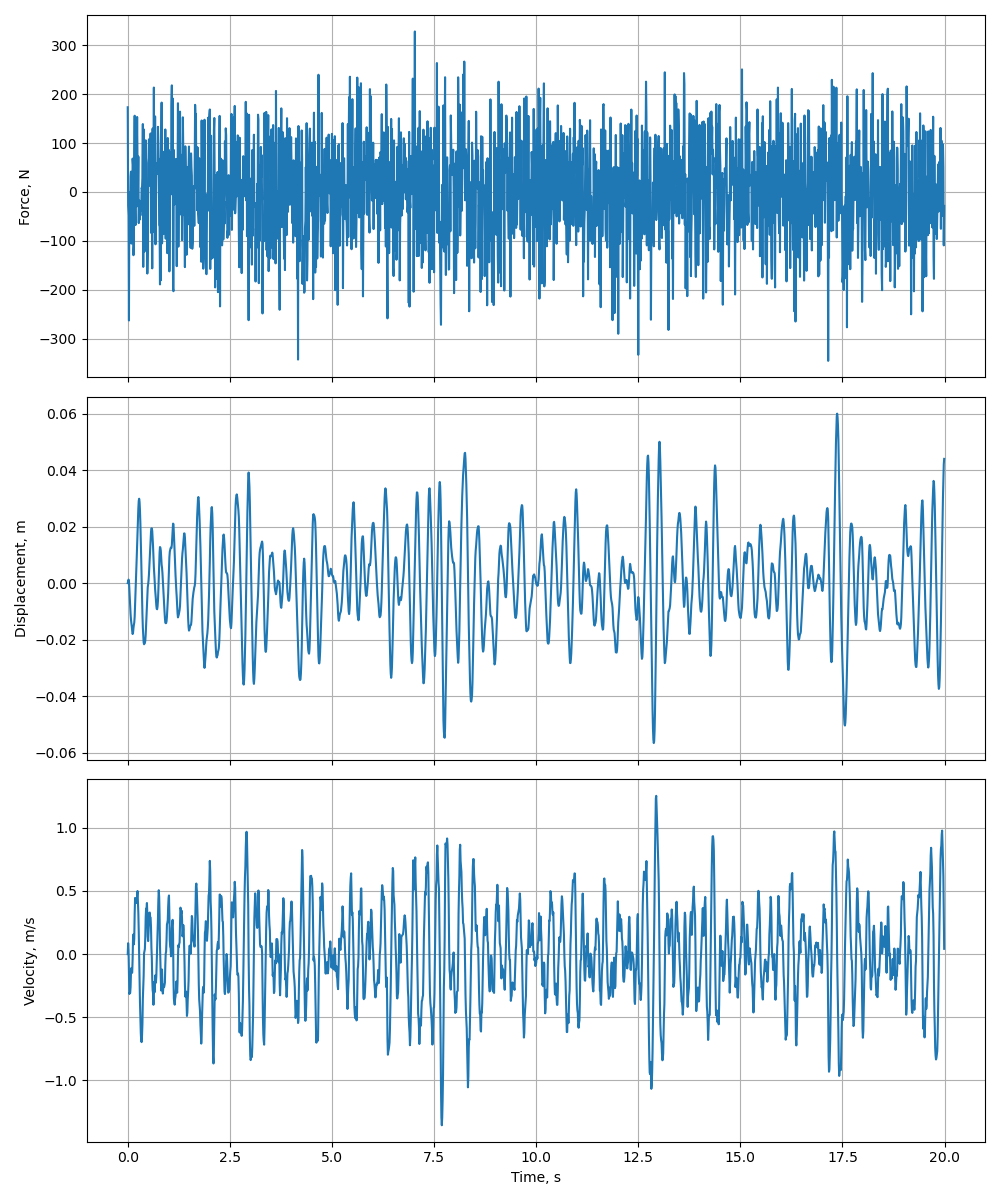

In [5]:
# Generate random force signal
np.random.seed(11)  # set random seed for reproducibility
random_signal = np.random.normal(
    size=len(t_vector)
)  # random signal with normal distribution centered at 0
random_force_signal = random_signal * (
    force_amplitude / np.sqrt(np.mean(random_signal**2))
)  # scale random signal to desired RMS [N]


# Create interpolated force function

random_force_function = interp1d(

    t_vector, random_force_signal, bounds_error=False, fill_value=0
)


# Solve ODE

solution = odeint(

    mass_spring_damper, initial_state, t_vector, args=(random_force_function,)
)


# Extract displacement and velocity

random_displacement = solution[:, 0]

random_velocity = solution[:, 1]


# Create figure with three subplots

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 12))


# Plot force

axes[0].plot(t_vector, random_force_signal)

axes[0].set_ylabel("Force, N")

axes[0].grid(True)


# Plot displacement

axes[1].plot(t_vector, random_displacement)

axes[1].set_ylabel("Displacement, m")

axes[1].grid(True)


# Plot velocity

axes[2].plot(t_vector, random_velocity)

axes[2].set_ylabel("Velocity, m/s")

axes[2].grid(True)

axes[2].set_xlabel("Time, s")


# Set layout and show plot

plt.tight_layout()

plt.show()

And finally we excite the system with an impulse force signal.

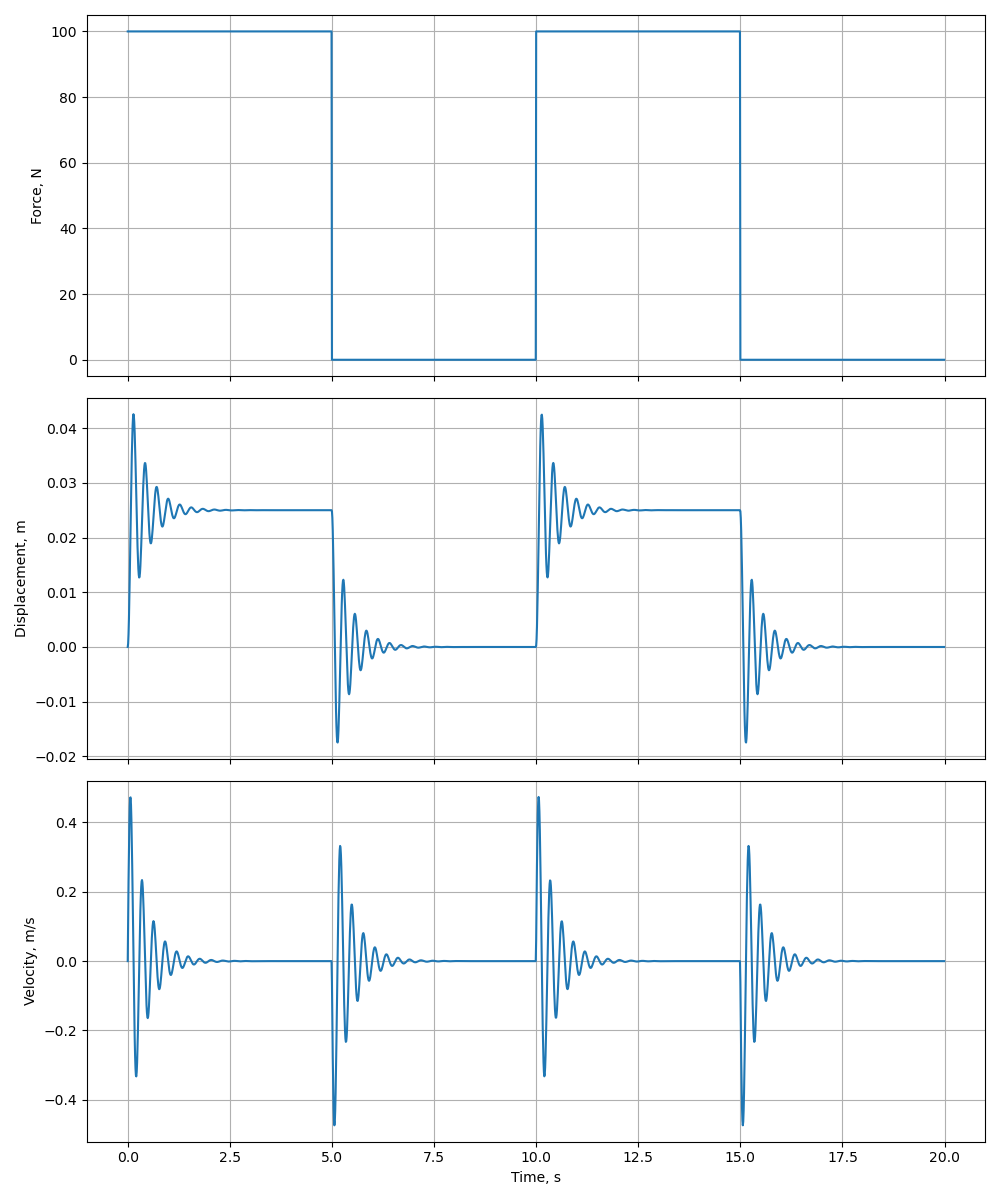

In [6]:
# Generate pulse force signal
no_pulses = 2  # number of pulses
pulse_width = t_span / (2 * no_pulses)  # pulse width [s]
no_samples_pulse = int(pulse_width * f_sampling)  # number of samples in pulse
pulse_force_signal = np.tile(
    np.hstack(
        [
            force_amplitude * np.ones(no_samples_pulse),
            np.zeros(no_samples_pulse),
        ]
    ),
    no_pulses,
)

# Create interpolated force function
pulse_force_function = interp1d(
    t_vector, pulse_force_signal, bounds_error=False, fill_value=0
)

# Solve ODE
solution = odeint(
    mass_spring_damper, initial_state, t_vector, args=(pulse_force_function,)
)

# Extract displacement and velocity
pulse_displacement = solution[:, 0]
pulse_velocity = solution[:, 1]

# Create figure with three subplots
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 12))

# Plot force
axes[0].plot(t_vector, pulse_force_signal)
axes[0].set_ylabel("Force, N")
axes[0].grid(True)

# Plot displacement
axes[1].plot(t_vector, pulse_displacement)
axes[1].set_ylabel("Displacement, m")
axes[1].grid(True)

# Plot velocity
axes[2].plot(t_vector, pulse_velocity)
axes[2].set_ylabel("Velocity, m/s")
axes[2].grid(True)
axes[2].set_xlabel("Time, s")

# Set layout and show plot
plt.tight_layout()
plt.show()

Now that we have generated our input and output signals, we can move on to the next step: selecting the model structure.

## Model Structure Selection <a name="model-structure-selection"></a>

***

As mentioned earlier, we are going to use a discrete-time AutoRegressive eXogenous (ARX) model to represent the system's dynamics. The ARX model is a linear regression model that predicts the discrete output signal $y$ at the sampling instant $j$ based on its past values and the discrete input signal $u$.

The model is defined by the following equation:

$$y[j] = -a_1y[j-1] - a_2y[j-2] + b_0u[j] + b_1u[j-1],$$

where the $[\,]$ notation indicates the discrete-time domain, $j-1$ and $j-2$ represent one and two sampling instants in the past, respectively, and $a_1$, $a_2$, $b_0$ and $b_1$ are the model parameters to be estimated.

You might be wondering: where does the ARX model come from? In short, the ARX model is derived from the system's continuous-time transfer function in the Laplace domain. This transfer function is transformed into the z-domain (the discrete-time equivalent of the Laplace domain), and then brought into the discrete-time domain to obtain the ARX model.

This process might sound complicated, but don't worry - we are going to derive the ARX model step-by-step. If you're not interested in the math, feel free to skip ahead to the next section. However, before you skip, it is important that you understand the fundamental idea behind what we are doing here.

We have assumed that the system's dynamics is represented by the equation above, the ARX model, and we are going to estimate the model parameters $a_1$, $a_2$, $b_0$ and $b_1$ in such a way to find the best fit between the output of the model and the measured output signal. You should realize that the success of this process depends on the suitability of the model structure to the system under investigation. If the model structure is not appropriate, no combination of parameters will be able to capture the system's dynamics, and the model will not be able to predict the system's behavior accurately.

In this case, we know that the ARX model is a good choice because it is derived directly from the system's continuous-time transfer function, which we know in the analytical form because of the simplicity of the 1-DOF mass-spring-damper system. This type of approach, where the model structure is derived from the system's physics, is called "white-box" modeling. In contrast, "black-box" modeling refers to cases where the model structure is chosen based on the data alone, without any prior knowledge of the system's dynamics. Finally, "grey-box" modeling is a combination of the two, where the model structure is chosen based on a mix of physics-based knowledge and data-driven insights.

Now let's tackle the derivation of the ARX model from the spring-mass-damper differential equation. Let's break this down into clear, logical steps.

1. **Take the Laplace transform**

Let's apply the Laplace transform to both sides of the equation. Remember that:
- $\mathcal{L}\left\{dx/dt\right\} = sX(s) - x(0)$
- $\mathcal{L}\left\{d²x/dt²\right\} = s²X(s) - sx(0) - \dot{x}(0)$

Assuming zero initial conditions ($x(0) = 0$ and $\dot{x}(0) = 0$), we get:

$$
m[s^2X(s)] + c[sX(s)] + kX(s) = F(s)
$$

Factoring out $X(s)$:

$$
X(s)(ms^2 + cs + k) = F(s)
$$

2. **Obtain the continuous transfer function**

The transfer function $H(s)$ is defined as the ratio of output to input:

$$
H(s) = \frac{X(s)}{F(s)} = \frac{1}{ms^2 + cs + k}
$$

3. **Convert the continuous transfer function to discrete time**

The transfer function $H(s)$ is obtained from the continuous-time system. However, the ARX model operates in discrete time, as it is based on the measured input and output signals. Consequently, we need to convert the continuous transfer function to discrete time, and we do this using the Zero-Order Hold (ZOH) transformation. This transformation corresponds to sampling a continuous signal at regular intervals, holding the value constant until the next sample.

The ZOH transformation involves multiplying $H(s)$ by the ZOH transfer function:

$$
H_{ZOH}(s) = \frac{1-e^{-sT}}{s} \cdot \frac{1}{ms^2 + cs + k},
$$

where $T$ is the sampling period. This gives us:

$$
H_{ZOH}(s) = \frac{1-e^{-sT}}{s(ms^2 + cs + k)}
$$

4. **Convert the ZOH transfer function to z-domain**

$H_{ZOH}(s)$ is the discrete transfer function, but it is still expressed in the $s$-domain. To obtain the ARX model, we need to convert it to the $z$-domain, which is the discrete-time equivalent of the $s$-domain. To convince you of this, recall that the Laplace transform converts a continuous-time signal $x(t)$ into its $s$-domain representation $X(s)$:

$$
\mathcal{L}\left\{x(t)\right\} = X(s) = \int_{0}^{\infty} x(t)e^{-st}dt,
$$

while the $z$-transform converts a discrete-time signal $x[j]$ into its $z$-domain representation $X(z)$:

$$
\mathcal{Z}\left\{x[j]\right\} = X(z) = \sum_{j=0}^{\infty} x[j]z^{-j}.
$$

To convert $H_{ZOH}(s)$ to the $z$-domain, it is necessary to perform partial fraction decomposition, which involves expressing $H_{ZOH}(s)$ as a sum of simpler fractions. To do this, we need to find the poles of the system, which are the roots of the denominator polynomial $s\left(ms^2 + cs + k\right)$. The poles are given by:

- $s=0$
- $s_{1,2} = \dfrac{-c \pm \sqrt{c^2 - 4mk}}{2m}$

For the partial fraction decomposition, we write:

$$
H_{ZOH}(s) = \frac{1-e^{-sT}}{s(ms^2 + cs + k)} = \frac{A}{s} + \frac{B}{s-s_1} + \frac{C}{s-s_2}.
$$

To find $A$, $B$, and $C$, we multiply both sides by $s(s-s_1)(s-s_2)$:

$$
1-e^{-sT} = A(s-s_1)(s-s_2) + Bs(s-s_2) + Cs(s-s_1)
$$

Then we solve for the coefficients by evaluating the expression at $s = 0$, $s = s_1$, and $s = s_2$:

At $s = 0$:
$$
1-1 = A(-s_1)(-s_2)
$$
Therefore:
$$
A = 0
$$

At $s = s_1$:
$$
1-e^{-s_1T} = Bs_1(s_1-s_2)
$$
Therefore:
$$
B = \frac{1-e^{-s_1T}}{s_1(s_1-s_2)}
$$

At $s = s_2$:
$$
1-e^{-s_2T} = Cs_2(s_2-s_1)
$$
Therefore:
$$
C = \frac{1-e^{-s_2T}}{s_2(s_2-s_1)}
$$

Finally, we can apply the $z$-transform properties. For any constant $\alpha$, the following transformation holds:

$$
\frac{1}{s-\alpha} \xrightarrow{\mathcal{Z}} \frac{z}{z-e^{\alpha T}}.
$$

Therefore:

$$
H(z) = B\frac{z}{z-e^{s_1T}} + C\frac{z}{z-e^{s_2T}}.
$$

Taking the sum of the two terms, we get:

$$
H(z) = \frac{\left(Bz\right)\left(z - e^{s_2T}\right) + \left(Cz\right)\left(z - e^{s_1T}\right)}{\left(z - e^{s_1T}\right)\left(z - e^{s_2T}\right)},
$$

which can be brought to the following form:

$$
H(z) = \frac{b_0z^2 + b_1z}{z^2 + a_1z + a_2},
$$

where:

$$
\begin{aligned}
a_1 &= -(e^{s_1T} + e^{s_2T}) \\
a_2 &= e^{(s_1+s_2)T} \\
b_0 &= B + C \\
b_1 &= -B e^{s_2T} - C e^{s_1T}.
\end{aligned}
$$

5. **Convert to ARX model**

Starting with our z-domain transfer function:

$$
\frac{Y(z)}{U(z)} = \frac{b_0z^2 + b_1z}{z^2 + a_1z + a_2},
$$

cross multiply:

$$
Y(z)(z^2 + a_1z + a_2) = U(z)(b_0z^2 + b_1z),
$$

expand:

$$
z^2Y(z) + a_1zY(z) + a_2Y(z) = b_0z^2U(z) + b_1zU(z),
$$

and divide both sides by $z^2$:

$$
Y(z) + a_1z^{-1}Y(z) + a_2z^{-2}Y(z) = b_0U(z) + b_1z^{-1}U(z).
$$

Now, recall that multiplication by $z^{-1}$ in the $z$-domain corresponds to a backward shift by one sample in the discrete-time domain. To convince you of this, recall the Laplace transform of a continuous signal delayed by a period $T$:

$$
\mathcal{L}\left\{x(t-T)\right\} = e^{-sT}X(s) = e^{-sT} \mathcal{L}\left\{x(t)\right\}.
$$

Similarly, for a discrete signal delayed by one sample, $x[j-1]$, the $z$-transform reads:

$$
\mathcal{Z}\left\{x[j-1]\right\} = z^{-1}X(z) = z^{-1} \mathcal{Z}\left\{x[j]\right\}.
$$

Consequently, translating the equation above to the time domain, we obtain the following expression:

$$
y[j] + a_1y[j-1] + a_2y[j-2] = b_0u[j] + b_1u[j-1],
$$

which, rearranged, gives us the ARX model:

$$
y[j] = -a_1y[j-1] - a_2y[j-2] + b_0u[j] + b_1u[j-1].
$$

## Parameter Estimation <a name="parameter-estimation"></a>

***

Now that we have generated our input and output signals and that we have chosen the ARX model to represent the system's dynamics, we can move on to the parameter estimation step.

The ARX model equation has 4 unknown parameters, meaning that we need 4 linearly independent equations to solve for them. These 4 equations correspond to 4 snapshots of the system's input and output signals:

$$
\begin{align}
&\left\{
    \begin{aligned}
    y[j] &= -a_1y[j-1] - a_2y[j-2] + b_0u[j] + b_1u[j-1] \\
    y[j-1] &= -a_1y[j-2] - a_2y[j-3] + b_0u[j-1] + b_1u[j-2] \\
    y[j-2] &= -a_1y[j-3] - a_2y[j-4] + b_0u[j-2] + b_1u[j-3] \\
    y[j-3] &= -a_1y[j-4] - a_2y[j-5] + b_0u[j-3] + b_1u[j-4].
    \end{aligned}
    \right.
\end{align}
$$

In practice, we can use all the acquired snapshots and find the combination of parameters that minimizes the error between the model's output and the measured output. In fact, in real-world applications, the measured data will always contain noise, and the goal of the parameter estimation process is to find the parameters that best describe the system's dynamics in the presence of this noise. In our present case, the only source of noise is the numerical solver's approximation error, which we can assume to be negligible given the small time step used in the simulation.

Given $N$ snapshots of the system's input and output signals, we can write the following system of $N-2$ equations:

$$
\begin{align}
&\left\{
    \begin{aligned}
    y[3] &= -a_1y[2] - a_2y[1] + b_0u[3] + b_1u[2]\\
    y[4] &= -a_1y[3] - a_2y[2] + b_0u[4] + b_1u[3]\\
    &\cdots \\
    y[N] &= -a_1y[N-1] - a_2y[N-2] + b_0u[N] + b_1u[N-1],
    \end{aligned}
\right.
\end{align}
$$

where we had to start from $j=3$ because the ARX model requires two past values of the input signal to predict the current value. The system can be written in matrix form as:

$$
\boldsymbol{Y} = \boldsymbol{\Phi}\boldsymbol{\theta},
$$

where:

- $\boldsymbol{Y} = \begin{bmatrix} y[3] & y[4] & \cdots & y[N] \end{bmatrix}^T$ is the output vector,

- $\boldsymbol{\Phi} = \begin{bmatrix} -y[2] & -y[1] & u[3] & u[2] \\ -y[3] & -y[2] & u[4] & u[3] \\ \vdots & \vdots & \vdots & \vdots \\ -y[N-1] & -y[N-2] & u[N] & u[N-1] \end{bmatrix}$ is the observation matrix,

- $\boldsymbol{\theta} = \begin{bmatrix} a_1 & a_2 & b_0 & b_1 \end{bmatrix}^T$ is the parameter vector.

The above system cannot be solved directly for $\boldsymbol{\theta}$ because $\boldsymbol{\Phi}$ is a rectangular matrix. To solve the system, we can use the least squares method, which minimizes the sum of the squared differences between the model's output and the measured output. The least squares solution is given by:

$$
\boldsymbol{\hat{\theta}} = (\boldsymbol{\Phi}^T\boldsymbol{\Phi})^{-1}\boldsymbol{\Phi}^T\boldsymbol{Y},
$$

where $\boldsymbol{\hat{\theta}}$ is the estimated parameter vector.

We can now define the function `estimate_arx_parameters` that takes the input and output signals, assembles the output vector and the observation matrix, and returns the estimated parameter vector.

In [7]:
def estimate_arx_parameters(y, u):
    """
    Estimate ARX parameters from input-output data using least squares method

    Parameters:
    y (array): Output data, shape (N,)
    u (array): Input data, shape (N,)

    Returns:
    array: ARX parameters [a1, a2, b0, b1], shape (4, 1)
    """
    # Find number of samples
    N = len(y)

    # Create ouput vector
    Y = np.atleast_2d(y[2:N]).T

    # Create observation matrix
    phi = np.vstack(
        [
            -y[1 : N - 1],
            -y[0 : N - 2],
            u[1 : N - 1],
            u[0 : N - 2],
        ]
    ).T

    # Calculate and return estimated parameter vector
    theta_hat = np.linalg.inv(phi.T @ phi) @ phi.T @ Y
    return theta_hat

Once we have calculated the estimated parameter vector, we can reuse the equation $\boldsymbol{Y} = \boldsymbol{\Phi}\boldsymbol{\hat{\theta}}$ to predict the system's output and compare the prediction with the measured output. To do this we define the function `compare_output`, which takes as input the input and output signals, the estimated parameter vector, and the time vector, and plots the measured and predicted output signals.

In [8]:
def compare_output(y, u, theta_hat, t):
    """
    Compare measured and estimated output using ARX parameters

    Parameters:
    y (array): Output data, shape (N,)
    u (array): Input data, shape (N,)
    theta_hat (array): ARX parameters, shape (4, 1)
    t (array): Time vector, shape (N,)

    Returns:
    Axes: Matplotlib Axes object
    """
    # Find number of samples
    N = len(y)

    # Iterate over time vector to calculate estimated output
    y_hat = np.zeros(N)
    y_hat[0] = y[0]
    y_hat[1] = y[1]
    for k in range(2, N):
        y_hat[k] = (
            -y_hat[k - 1] * theta_hat[0, 0]
            - y_hat[k - 2] * theta_hat[1, 0]
            + u[k] * theta_hat[2, 0]
            + u[k - 1] * theta_hat[3, 0]
        )

    # Plot measured and predicted output
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(t, y, label="Measured")
    ax.plot(t, y_hat, label="Estimated")
    ax.set_xlabel("Time, s")
    ax.set_ylabel("Displacement, m")
    ax.legend()
    ax.grid(True)

    # Return Axes object
    return ax

Now it's finally time to estimate the ARX model parameters and compare the predicted output with the measured output for the three different excitation signals.

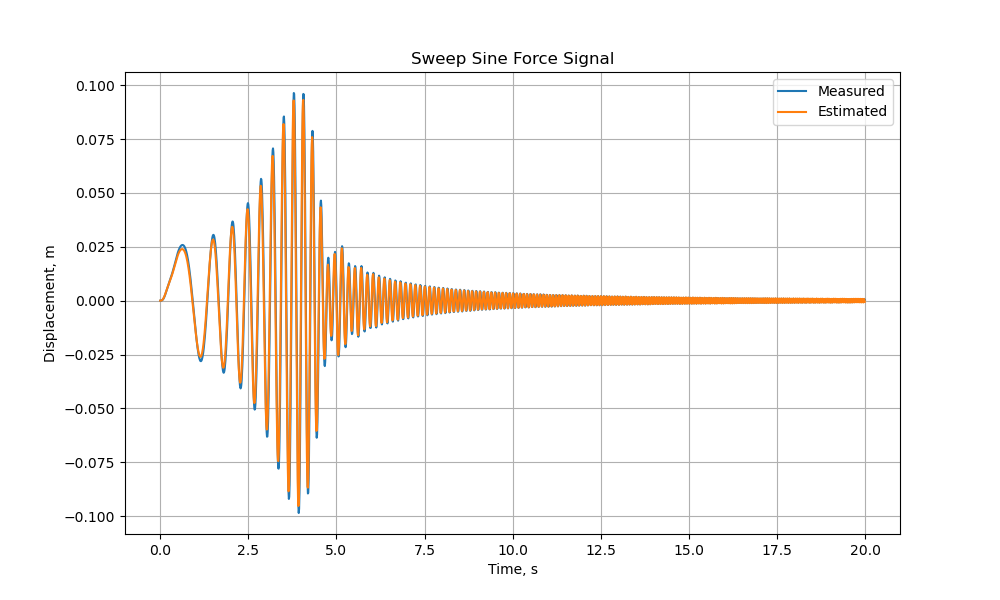

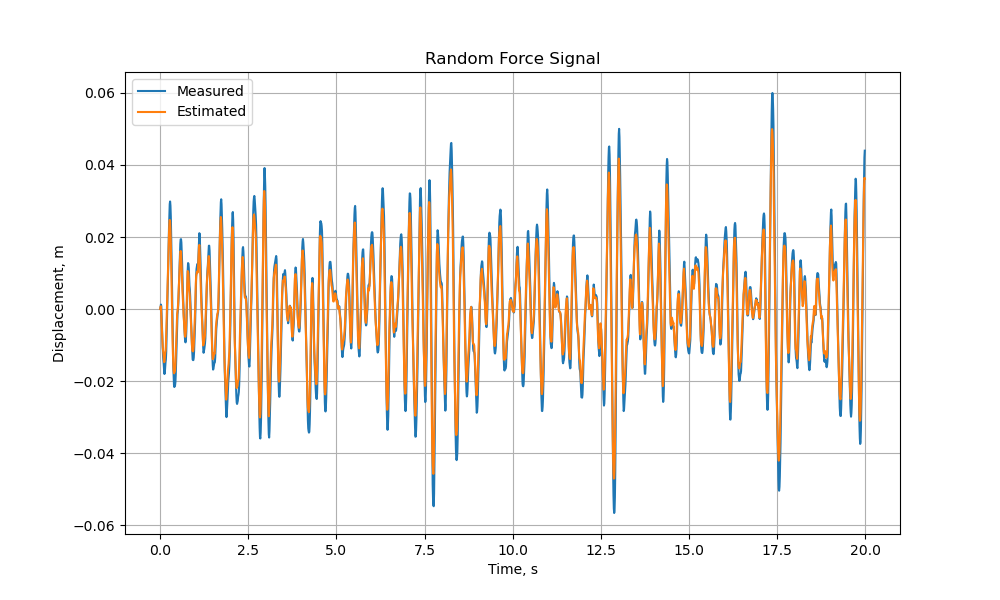

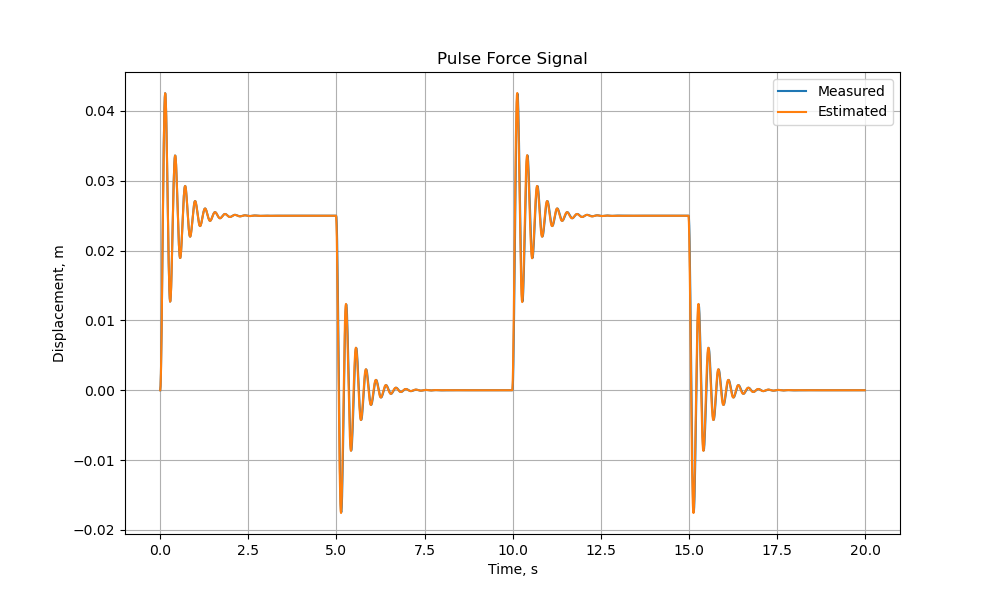

In [9]:
# Calculate ARX parameters for sweep sine force signal and compare output
sweep_sine_arx_parameters = estimate_arx_parameters(
    sweep_sine_displacement, sweep_sine_force_signal
)
ax = compare_output(
    sweep_sine_displacement,
    sweep_sine_force_signal,
    sweep_sine_arx_parameters,
    t_vector,
)
ax.set_title("Sweep Sine Force Signal")
plt.show()

# Calculate ARX parameters for random force signal and compare output
random_arx_parameters = estimate_arx_parameters(
    random_displacement, random_force_signal
)
ax = compare_output(
    random_displacement, random_force_signal, random_arx_parameters, t_vector
)
ax.set_title("Random Force Signal")
plt.show()

# Calculate ARX parameters for pulse force signal and compare output
pulse_arx_parameters = estimate_arx_parameters(pulse_displacement, pulse_force_signal)
ax = compare_output(
    pulse_displacement, pulse_force_signal, pulse_arx_parameters, t_vector
)
ax.set_title("Pulse Force Signal")
plt.show()

We can observe that the ARX model is able to predict the system's output for all three excitation signals, however with different levels of accuracy. The model that appears to perform best is the one estimated using the pulse signal, as we cannot see any difference between the measured and predicted output signals. The other two models appear to correctly predict well the overall response of the system under the respective excitation conditions, but they do not capture well the peaks of the output signal. While for the model estimated using the chirp signal the difference is relatively small, the model estimated using the random signal shows a larger discrepancy between the measured and predicted output signals.

The pulse signal produces the best model fit because it effectively excites the system's natural dynamics while maintaining clear separation between input events. When the pulse force is applied, it creates a clear sequence of system responses. First, we observe the forced response during the pulse, followed by a free vibration phase where the system oscillates freely without any external force. This clean separation between forced and free responses provides rich information about both how the system reacts to external forces and how it behaves naturally, helping the parameter estimation process capture the system's dynamics more accurately.

The sweep sine and random force signals present a more challenging scenario because they continuously excite the system, making it harder to distinguish between the effects of current and past inputs in the system's response. With the sweep sine signal, the continuously changing frequency of excitation creates overlapping dynamic effects that the model struggles to capture precisely, leading to the observed discrepancies in the output signal peaks. The random force signal presents an even greater challenge because its irregular nature means the system is constantly being forced in unpredictable ways, never allowing a clear observation of its natural behavior. This explains why we observe the largest discrepancies between measured and predicted outputs in this case.

## Model Validation <a name="model-validation"></a>

***

The final step in the system identification process is model validation. In this step, we evaluate the performance of the estimated model against unseen input and output signals.

Similarly to what we did earlier, we can multiply the observation matrix assembled from the unseen data with the estimated paramter vector to predict the output signal. We can then compare the predicted output signal with the measured output signal to assess the model's accuracy.

We are going to validate the ARX model that we have obtained for each of our three input signals against the data of the other two input signals.

Let's start by validating the ARX model obtained with the sweep sine excitation.

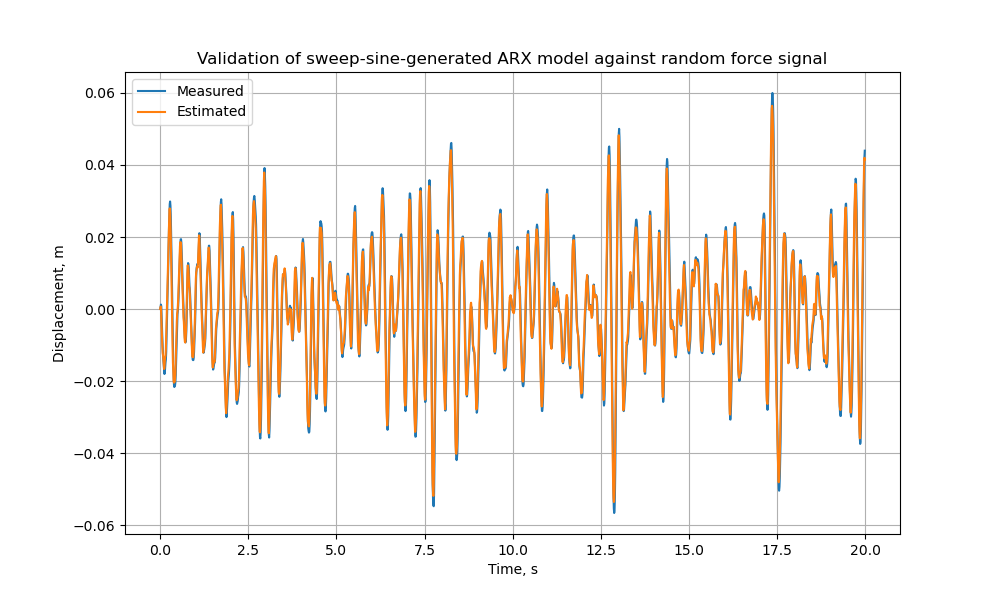

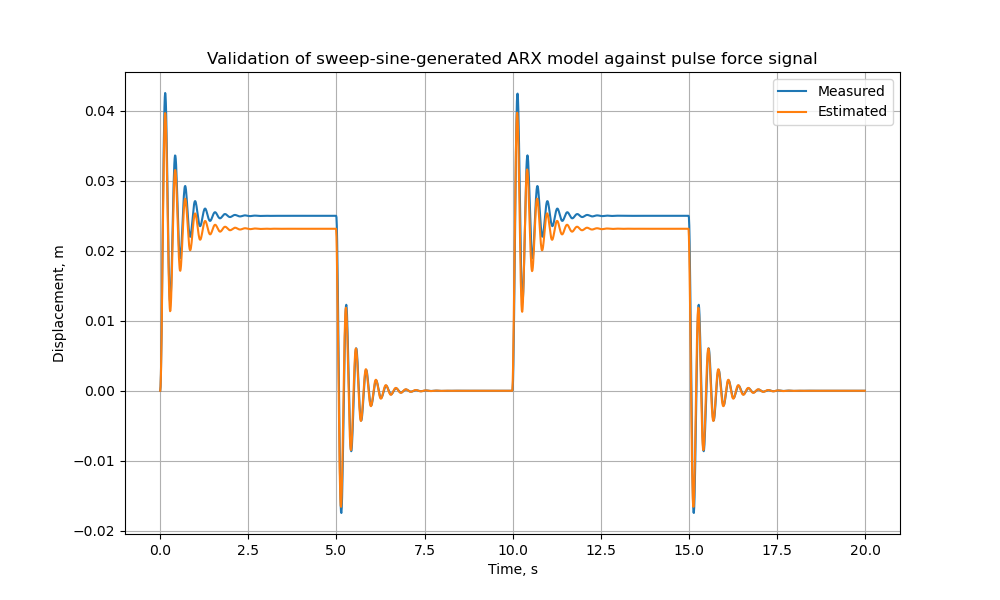

In [10]:
# Validate ARX model obtained from sweep sine force signal against random force signal data
ax = compare_output(
    random_displacement, random_force_signal, sweep_sine_arx_parameters, t_vector
)
ax.set_title("Validation of sweep-sine-generated ARX model against random force signal")
plt.show()

# Validate ARX model obtained from sweep sine force signal using pulse force signal data
ax = compare_output(
    pulse_displacement, pulse_force_signal, sweep_sine_arx_parameters, t_vector
)
ax.set_title("Validation of sweep-sine-generated ARX model against pulse force signal")
plt.show()

The sweep-sine-generated ARX model predicts well the system's response for the random excitation, except for small discrepancies at the signal peaks. However, the model does not perform as well for the impulse excitation, showing significant deviations from the measured output signal when the pulse force is applied. Altough the dynamics of the system appear to be well captured, as the dynamic response decays in the same way as the measured output signal, the model is not able to predict the correct steady-state displacement when the pulse force is applied. This result seems to be related to the underprediction of the response peaks observed earlier, which is likely to cause the model to underestimate also the steady-state displacement.

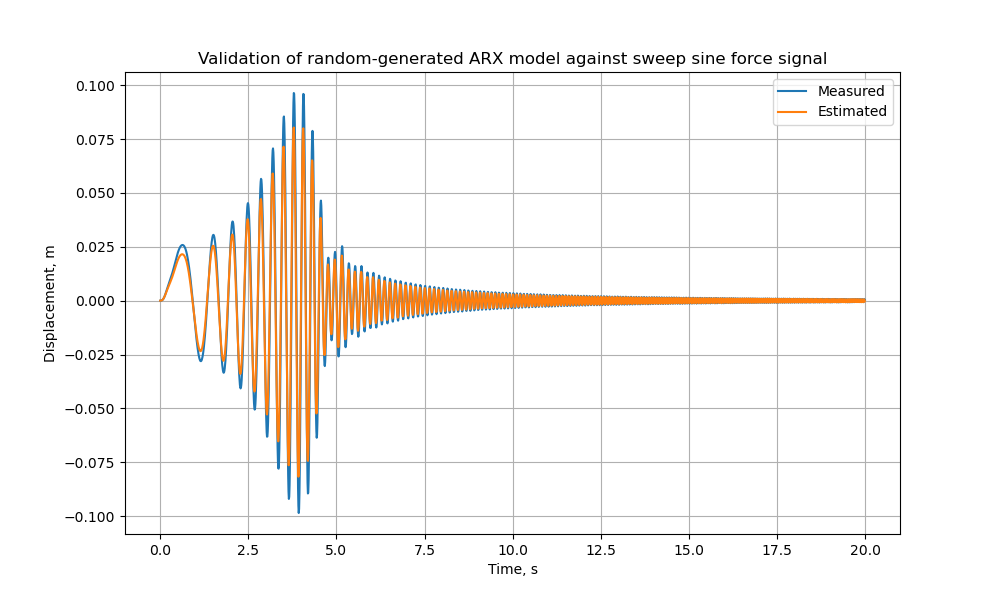

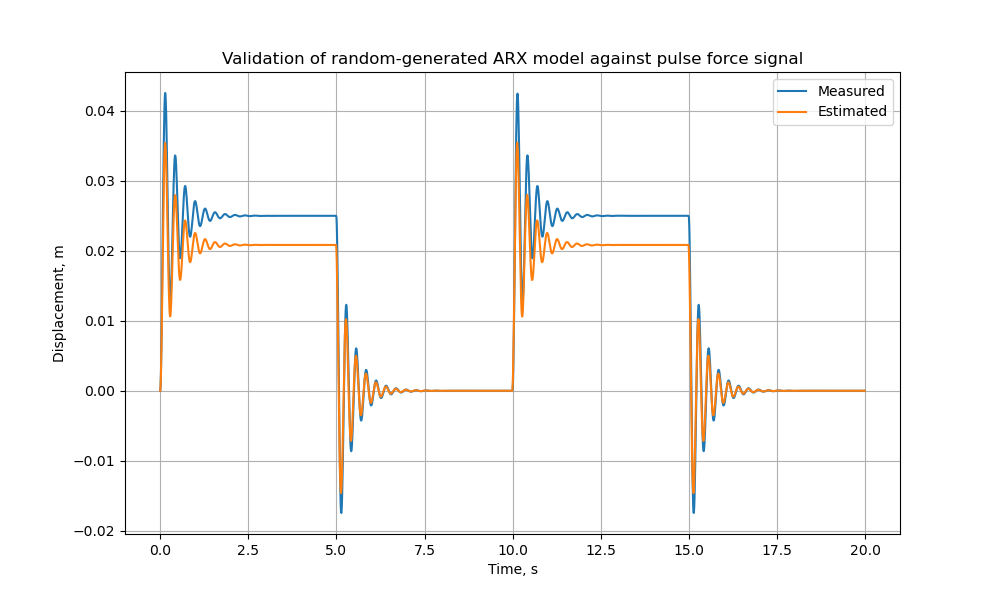

In [11]:
# Validate ARX model obtained from random force signal using sweep sine force signal data
ax = compare_output(
    sweep_sine_displacement, sweep_sine_force_signal, random_arx_parameters, t_vector
)
ax.set_title("Validation of random-generated ARX model against sweep sine force signal")
plt.show()

# Validate ARX model obtained from random force signal using pulse force signal data
ax = compare_output(
    pulse_displacement, pulse_force_signal, random_arx_parameters, t_vector
)
ax.set_title("Validation of random-generated ARX model against pulse force signal")
plt.show()

The results for the ARX model estimated with the random excitation show a similar pattern to those of the sweep-sine-generated model. The model captures well the overall dynamic response of the system, it generally performs better for the sine sweep excitation, and it struggles to predict the system's steady-state response for the impulse excitation. However, this time the discrepancies in terms of the response peaks and of the steady-state displacement are more pronounced. This result is in agreement to what we observed earlier, where the model estimated with the random excitation showed the largest discrepancies between measured and predicted output signals compared to the other two models.

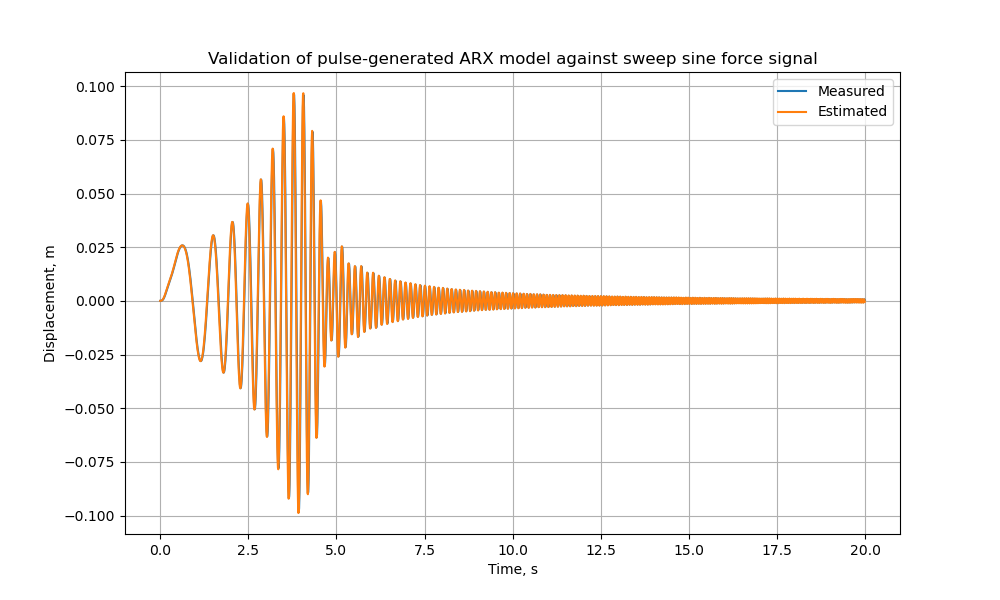

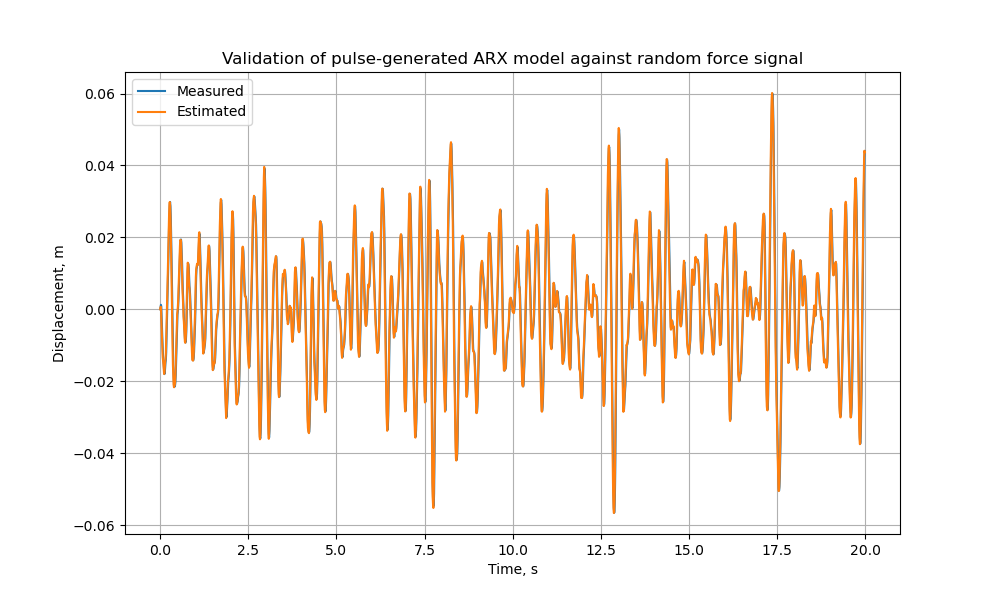

In [12]:
# Validate ARX model obtained from pulse force signal using sweep sine force signal data
ax = compare_output(
    sweep_sine_displacement, sweep_sine_force_signal, pulse_arx_parameters, t_vector
)
ax.set_title("Validation of pulse-generated ARX model against sweep sine force signal")
plt.show()

# Validate ARX model obtained from pulse force signal using random force signal data
ax = compare_output(
    random_displacement, random_force_signal, pulse_arx_parameters, t_vector
)
ax.set_title("Validation of pulse-generated ARX model against random force signal")
plt.show()

Finally, the ARX model estimated with the pulse excitation shows the best performance among the three models, as the predicted output signals are almost identical to the measured output signals for both the sine sweep and random excitations. This result is consistent with the previous observations, where the pulse excitation appeared to provide the most informative data for the parameter estimation process, leading to a more accurate model representation of the system's dynamics.

## Conclusion <a name="conclusion"></a>

***

In this notebook, we have explored the system identification process using a 1-DOF mass-spring-damper system as a case study. We have generated synthetic data for the system's input and output signals using three different excitation signals: sweep sine, random force, and impulse force. We have then derived the ARX model from the system's continuous-time transfer function and estimated the model parameters using the least squares method. Finally, we have validated the estimated model against unseen data for each of the three excitation signals.

The results of the system identification process have shown that the ARX model is able to predict the system's dynamics with varying degrees of accuracy depending on the excitation signal used for the parameter estimation. The model estimated with the pulse excitation has shown the best performance, while the models estimated with the sweep sine and random force signals have shown some discrepancies between the measured and predicted output signals. These results highlight the importance of selecting an appropriate excitation signal depending on the selected model structure and the underlying system's dynamics.

We have purposely avoided to talk about many important aspects of system identification, such as the effect of noise on the estimation process, the frequency domain analysis of the system's dynamics, the model order selection, and the model validation metrics. The goal of this notebook was to provide a simple introduction to system identification concepts, and we hope that we have achieved this goal.

Despite the success of the ARX model in predicting the system's dynamics, this identification approach did not provide us with valuable insights into some important properties of the system. In fact, imagine we did not know the value of the system's mass, spring constant, and damping coefficient. How could we estimate the system's natural frequency and damping ratio? The ARX model allows us to predict the system's output based on the input signal, but it does not provide us with a direct way to extract the system's natural frequency and damping ratio.

In the next notebook, we are going to keep exploring the identification of our 1-DOF mass-spring-damper system, but this time we are going to use a different model structure that will allow us to extract the system's natural frequency and damping ratio. Stay tuned!